# Logistic Regression

In [29]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk import word_tokenize, sent_tokenize          

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight

import tiktoken
from nltk import WordNetLemmatizer


In [2]:
# Load the data
from utils import load_wikipedia_dataset

df_train, df_test = load_wikipedia_dataset('../data/dataset.csv')


In [3]:
df_train.head()

,text,category
3413,Deliverance is a 1919 silent film which tells ...,films
188839,Fleeceware is a type of malware mobile applica...,war
186580,Joyce Seamone is a Canadian country singer. Sh...,singers
30088,"Lacena Golding-Clarke (born March 20, 1975 in ...",sports
9271,Baiae (; ) was an ancient Roman town situated ...,geography


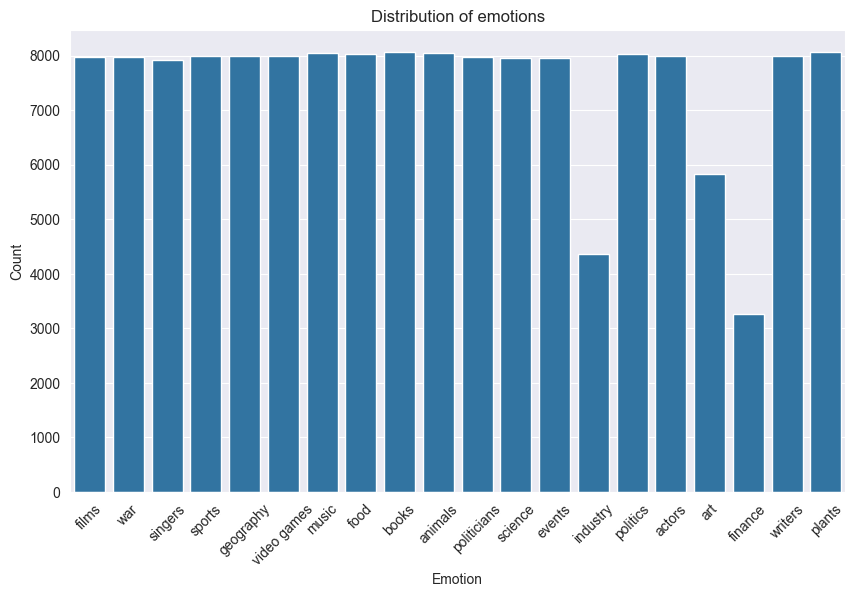

In [4]:
# Visualize the distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=df_train)

plt.title('Distribution of emotions') 
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

## Training Word2Vec

In [6]:
X_list = list(df_train["text"])[:1000]
X_strings = " ".join(X_list)
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

In [15]:
model = Word2Vec(sentences=X_sents, vector_size=100, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [19]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
# vector = wv['war']
sims = wv.most_similar('Fono', topn=10)
sims

[('scene', 0.9597601890563965),
 ('project', 0.9499327540397644),
 ('walk', 0.9485291838645935),
 ('start', 0.946542501449585),
 ('date', 0.9439146518707275),
 ('reset', 0.9427158236503601),
 ('course', 0.9421923160552979),
 ('window', 0.9404671788215637),
 ('ending', 0.9382332563400269),
 ('charge', 0.9380831122398376)]

### Embed documents using Word2vec


In [22]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [23]:
document_vector("hello i'm gustave", wv)

array([-0.2774254 ,  0.36211804,  0.17750037,  0.25554258, -0.15250024,
       -0.38299036,  0.3019267 ,  0.18685092, -0.42501438, -0.2408869 ,
        0.05411497, -0.12355871, -0.04860854,  0.24036601,  0.33797276,
        0.07893269,  0.3434704 , -0.4788785 , -0.17597291, -0.5495835 ,
        0.03038103,  0.3269842 ,  0.10781687, -0.08832636, -0.2487819 ,
        0.52202785, -0.26600394, -0.18229382, -0.1071144 , -0.12340415,
        0.15845127,  0.20614935,  0.46058005, -0.1289119 , -0.24113327,
        0.04930837,  0.03695841,  0.12905052,  0.25648102, -0.39991304,
        0.13504316, -0.04713326, -0.06347372, -0.01454814,  0.09735451,
        0.03538879, -0.07868318,  0.00181638,  0.07977846,  0.17405552,
       -0.1901753 ,  0.08736679, -0.31907558,  0.03382405,  0.25073963,
       -0.17138964, -0.04413906, -0.12620744,  0.12948412,  0.07779362,
        0.2099988 , -0.05882809,  0.1140082 ,  0.0705218 , -0.1621332 ,
        0.19380513, -0.24056682,  0.03358796, -0.59014225,  0.38

## Training and test sets for Word2vec


In [27]:
X = df_train['text'][:1000]
y = df_train['category'][:1000]

X = np.array([document_vector(text, wv) for text in X])
#X = np.array([document_vector(text, pretrained_wv) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (800, 100)


## Training and test sets for tf-idf

In [28]:
X = df_train['text'][:1000]
y = df_train['category'][:1000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Tokenization functions


In [30]:

def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

def gpt_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

## Training: Logistic regression


In [31]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [34]:
label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

In [35]:
integer_encoded

array([ 5, 18, 15, 16,  8, 17, 10, 18, 15, 15,  7,  3,  1, 12, 14,  4,  3,
       12,  8, 10,  5,  9,  7, 13, 17, 14,  3,  5, 18, 15,  7,  8, 15, 17,
        0,  9,  2,  6, 13,  8,  2,  7, 15,  8, 18, 13, 13, 19, 18, 10,  3,
        8,  8, 10,  8,  4, 17,  4, 13,  0,  8, 18, 14,  6, 10,  2,  8, 18,
        1, 18,  5, 13,  5, 19, 12,  1, 14, 14,  7,  9,  2,  8,  7,  8, 16,
       18, 13,  8,  0,  6, 15,  0, 17,  1, 16, 10, 14,  8,  4, 13,  0, 16,
       19,  1, 13,  0, 13, 13,  5,  1, 13, 12,  4, 19, 17, 14,  9,  7, 12,
        2,  2, 17,  8, 17, 12,  3, 19,  3, 19,  0, 18,  7, 18, 15, 12,  5,
        5, 18,  7, 18, 15,  7,  5, 18,  5,  7,  2,  5,  0, 16,  1,  2,  8,
       16,  5, 11,  1, 11, 13, 18,  5,  4,  9,  2,  1, 16,  1, 16, 12,  6,
        4,  3, 13, 17,  1,  1, 15, 16, 12,  3,  5, 18, 19,  9, 17,  4, 18,
        4, 10, 14, 18, 11, 19,  5,  8, 18,  4, 10, 11, 10, 12, 14, 13,  0,
        0, 16,  3, 15, 12,  0,  0,  2,  5,  8,  7, 17,  1, 15, 14, 17, 11,
       11, 13,  3,  4,  8

In [42]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


NameError: name '_C' is not defined

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F

class LogisticRegressionModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(vocab_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = LogisticRegressionModel(vocab_size, num_classes)
#model = MultiLayerPerceptron2(vocab_size, 10, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.AdamW(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

NameError: name '_C' is not defined